# FNGS Tutorial
To start, let's take a look inside the fngs_pipeline() module, which computes derivatives on a single subject's fMRI graphs. Like the ndmg-dti pipeline, the FNGS pipeline makes use of internally exposed modules that can easily be combined differently to vary preprocessing technique.

To begin, we import our dependencies:

In [1]:
from argparse import ArgumentParser
from datetime import datetime
from subprocess import Popen, PIPE
import os.path as op
from ndmg.utils import utils as mgu 
from ndmg.register import register as mgr 
from ndmg import graph as mgg 
import numpy as np
import nibabel as nb
from ndmg.timeseries import timeseries as mgts
from ndmg.stats import fmri_qc as mgqc
from ndmg.preproc import preproc_fmri as mgp 
from ndmg.nuis import nuis as mgn

The local variables we must set for the fngs pipeline are as follows:

In [2]:
fmri = '../tests/data/KKI2009_113_1_fMRI_s4.nii.gz'
struct = '../tests/data/KKI2009_113_1_MPRAGE_s4.nii'
atlas = '../tests/data/MNI152_T1_1mm_s4.nii.gz'
atlas_brain = '../tests/data/MNI152_T1_1mm_brain_s4.nii.gz'
mask = '../tests/data/MNI152_T1_1mm_brain_mask_s4.nii.gz'
labels = ['../tests/data/desikan_s4.nii.gz']
outdir = '../tests/data/outputs'

fmt = 'graphml'

First, we prepare our file names as follows:

In [3]:
fmri_name = op.splitext(op.splitext(op.basename(fmri))[0])[0]
struct_name = op.splitext(op.splitext(op.basename(struct))[0])[0]
atlas_name = op.splitext(op.splitext(op.basename(atlas))[0])[0]

qcdir = outdir + "/qc"
mcdir = qcdir + "/mc/" + fmri_name
regdir = qcdir + "/reg/" + fmri_name
overalldir = qcdir + "/overall/" + fmri_name
roidir = qcdir + "/roi/" + fmri_name

cmd = "mkdir -p " + outdir + "/reg_fmri " + outdir +\
    "/preproc_fmri " + outdir + "/motion_fmri " + outdir +\
    "/voxel_timeseries " + outdir + "/roi_timeseries " +\
    outdir + "/reg_struct " + outdir + "/tmp " +\
    outdir + "/graphs " + outdir + "/nuis_fmri " + qcdir + " " +\
    mcdir + " " + regdir + " " + overalldir + " " + roidir
mgu().execute_cmd(cmd)

# Graphs are different because of multiple atlases
if isinstance(labels, list):
    label_name = [op.splitext(op.splitext(op.basename(x))[0])[0]
                  for x in labels]
    for label in label_name:
        p = Popen("mkdir -p " + outdir + "/roi_timeseries/" + label,
                  stdout=PIPE, stderr=PIPE, shell=True)
        p = Popen("mkdir -p " + outdir + "/graphs/" + label,
                  stdout=PIPE, stderr=PIPE, shell=True)
else:
    label_name = op.splitext(op.splitext(op.basename(labels))[0])[0]
    p = Popen("mkdir -p " + outdir + "/roi_timeseries/" + label_name,
              stdout=PIPE, stderr=PIPE, shell=True)
    p = Popen("mkdir -p " + outdir + "/graphs/" + label_name,
              stdout=PIPE, stderr=PIPE, shell=True)
        
# Create derivative output file names
preproc_fmri = outdir + "/preproc_fmri/" + fmri_name + "_preproc.nii.gz"
aligned_fmri = outdir + "/reg_fmri/" + fmri_name + "_aligned.nii.gz"
aligned_struct = outdir + "/reg_struct/" + fmri_name +\
    "_anat_aligned.nii.gz"
motion_fmri = outdir + "/motion_fmri/" + fmri_name + "_mc.nii.gz"
nuis_fmri = outdir + "/nuis_fmri/" + fmri_name + "_nuis.nii.gz"
voxel_ts = outdir + "/voxel_timeseries/" + fmri_name + "_voxel.npz"
   
# Again, graphs are different
graphs = [outdir + "/graphs/" + x + '/' + fmri_name + "_" + x + '.' + fmt
            for x in label_name]
roi_ts = [outdir + "/roi_timeseries/" + x + '/' + fmri_name + "_" + x +
            ".npz" for x in label_name]
print "ROI timecourse downsampled to given labels: " +\
    (", ".join([x for x in roi_ts]))

Executing: mkdir -p ../tests/data/outputs/reg_fmri ../tests/data/outputs/preproc_fmri ../tests/data/outputs/motion_fmri ../tests/data/outputs/voxel_timeseries ../tests/data/outputs/roi_timeseries ../tests/data/outputs/reg_struct ../tests/data/outputs/tmp ../tests/data/outputs/graphs ../tests/data/outputs/nuis_fmri ../tests/data/outputs/qc ../tests/data/outputs/qc/mc/KKI2009_113_1_fMRI_s4 ../tests/data/outputs/qc/reg/KKI2009_113_1_fMRI_s4 ../tests/data/outputs/qc/overall/KKI2009_113_1_fMRI_s4 ../tests/data/outputs/qc/roi/KKI2009_113_1_fMRI_s4
ROI timecourse downsampled to given labels: ../tests/data/outputs/roi_timeseries/desikan_s4/KKI2009_113_1_fMRI_s4_desikan_s4.npz


Now that we have set all of our variable names, we are ready to get into some fMRI processing.

## Preprocessing
To begin, we need to preprocess our inputs. Preprocessing consists of removing intuitive subject-specific artifacts present in our images. We perform motion correction to remove subject scanner motion (that is, the movement of the subject's head in the scanner). This is accomplished with an affine alignment algorithm, mcflirt, whereby we assume that our subject's head dimensions are fixed but may not necessarily align in time due to rotational and translational motion in the x, y, and z axis (6 parameter model). In this way, we have translated each 3D image in our 4D stack to align in a subject-specific brainspace, or the qualitative shape of the brain.

In [4]:
print "Preprocessing volumes..."
mgp().preprocess(fmri, preproc_fmri, motion_fmri, outdir, qcdir=mcdir)

Preprocessing volumes...
Executing: mcflirt -in ../tests/data/KKI2009_113_1_fMRI_s4.nii.gz -out ../tests/data/outputs/motion_fmri/KKI2009_113_1_fMRI_s4_mc.nii.gz -plots -refvol 0
Performing Quality Control for Motion Correction...
	Before Motion Correction: ../tests/data/KKI2009_113_1_fMRI_s4.nii.gz
	After Motion Correction: ../tests/data/outputs/motion_fmri/KKI2009_113_1_fMRI_s4_mc.nii.gz
	Reference Motion Correction: ../tests/data/outputs/tmp/KKI2009_113_1_fMRI_s4_0slice.nii.gz
Executing: mkdir -p ../tests/data/outputs/qc/mc/KKI2009_113_1_fMRI_s4


/home/eric/anaconda2/lib/python2.7/site-packages/ndmg-0.0.31-py2.7.egg/ndmg/stats/fmri_qc.py:285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/eric/anaconda2/lib/python2.7/site-packages/ndmg-0.0.31-py2.7.egg/ndmg/stats/fmri_qc.py:288: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Executing: cp ../tests/data/outputs/motion_fmri/KKI2009_113_1_fMRI_s4_mc.nii.gz ../tests/data/outputs/preproc_fmri/KKI2009_113_1_fMRI_s4_preproc.nii.gz


## Alignment
Now that we have preprocessed our graphs and our confident our entire image is aligned relative the subject-specific brainspace, we are ready to align our images to a more generalized brain space. When making inferences from an fMRI scan, it is nearly impossible to conduct sizable analyses manually. For this reason, researchers will use alignment to adjust voxels as necessary in a subject-specific brain space to match that of a template brain. A template brain is a scan that is usually some sort of approximation of the "average" brain of the subjects in the particular study that a template is derived from. We will use non-linear registration here, which means that we will have scaling approximated for each voxel in the image based on anatomical features present in the image (not simply warping x, y, or z direction linearly, contrary to some processing pipelines). 

In [5]:
print "Aligning Volumes..."
mgr().fmri2atlas(preproc_fmri, struct, atlas, atlas_brain, mask,
                 aligned_fmri, aligned_struct, outdir, qcdir=regdir)

Aligning Volumes...
Executing: bet ../tests/data/KKI2009_113_1_MPRAGE_s4.nii ../tests/data/outputs/tmp/KKI2009_113_1_fMRI_s4_preproc_anat_brain.nii.gz 
Executing: bet ../tests/data/outputs/tmp/KKI2009_113_1_fMRI_s4_preproc_0slice.nii.gz ../tests/data/outputs/tmp/KKI2009_113_1_fMRI_s4_preproc_0slice_brain.nii.gz 
Executing: flirt -in ../tests/data/outputs/tmp/KKI2009_113_1_fMRI_s4_preproc_0slice_brain.nii.gz -ref ../tests/data/outputs/tmp/KKI2009_113_1_fMRI_s4_preproc_anat_brain.nii.gz -interp trilinear -omat ../tests/data/outputs/tmp/KKI2009_113_1_fMRI_s4_preproc_xfm_func2mpr.mat -dof 12 -searchrx -180 180 -searchry -180 180 -searchrz -180 180
Executing: flirt -in ../tests/data/outputs/tmp/KKI2009_113_1_fMRI_s4_preproc_anat_brain.nii.gz -ref ../tests/data/MNI152_T1_1mm_brain_s4.nii.gz -interp trilinear -omat ../tests/data/outputs/tmp/KKI2009_113_1_fMRI_s4_preproc_xfm_mpr2temp.mat -dof 12 -searchrx -180 180 -searchry -180 180 -searchrz -180 180
Executing: fnirt --in=../tests/data/KKI200

## Nuisance Correction
After alignment to a template image, we will regress out some other subject-specific artifacts that may be present, but are more convenient for a variety of reasons to leave in until now. So far, we have only included high pass filtering to our nuisance pipeline, where we filter out any frequencies lower than .01 Hz. Relevant brain signals are not generally at this low frequency, so simply removing them can reduce a lot of scanner-specific noise present in our data.

In [6]:
mgn().nuis_correct(aligned_fmri, nuis_fmri)

Executing: fslmaths ../tests/data/outputs/reg_fmri/KKI2009_113_1_fMRI_s4_aligned.nii.gz -bptf 50.0 -1 ../tests/data/outputs/nuis_fmri/KKI2009_113_1_fMRI_s4_nuis.nii.gz


## Timeseries Extraction
Most researchers will be concerned with either a voxel or ROI timeseries. Voxel timeseries is simply extracting the timeseries for voxels that are specified in an atlas to be brain voxels. This "mask" that tells us whether a voxel is brain or not must be derived from the same study as the atlas and atlas_brain we use previously, or we run the risk of losing brain voxels/including out-of-brain voxels depending on how the mask aligns with our brains (note that our brains are in a specific atlas brain space, so masking with a different brain space would remove a different "shape" from our images). Likewise, roi timeseries involves extracting voxel intensities, except for a significant difference: while in voxel timeseries we extract a timeseries for each voxel, in the ROI timeseries we average the intensity over time of voxels that are specified to be part of a particular region in a label file. This label file must be of the same space as the atlas as well, or we would run the risk of mischaracterizing brain regions in downstream analyses.

For each roi timeseries, we also provide a correlation matrix derivative. This derivative corresponds to the correlation between the timeseries of each roi in our labelled atlas.

In [9]:
voxel = mgts().voxel_timeseries(nuis_fmri, mask, voxel_ts)

for idx, label in enumerate(label_name):
    print "Extracting roi timeseries for " + label + " parcellation..."
    try:
        ts = mgts().roi_timeseries(nuis_fmri, labels[idx], roi_ts[idx],
                               qcdir=roidir,
                               scanid=fmri_name, refid=label)
        mgqc().image_align(atlas_brain, labels[idx], roidir, scanid=atlas_name,
                           refid=label)
    except OSError as err:
        print(err)
    graph = mgg(ts.shape[0], labels[idx], sens="Functional")
    graph.cor_graph(ts)
    graph.summary()
    
    graph.save_graph(graphs[idx], fmt=fmt)

Extracting Voxel Timeseries for ../tests/data/outputs/nuis_fmri/KKI2009_113_1_fMRI_s4_nuis.nii.gz...
Extracting roi timeseries for desikan_s4 parcellation...
Executing: mkdir -p ../tests/data/outputs/qc/roi/KKI2009_113_1_fMRI_s4
Executing: mkdir -p ../tests/data/outputs/qc/roi/KKI2009_113_1_fMRI_s4
{'ecount': 0, 'vcount': 70, 'region': 'brain', 'source': 'http://m2g.io', 'version': '0.0.31', 'date': 'Sun Sep 18 23:28:09 2016', 'sensor': 'Functional MRI', 'name': "Generated by NeuroData's MRI Graphs (ndmg)"}
Estimating correlation matrix for 70 roi graph...

 Graph Summary:
Name: Generated by NeuroData's MRI Graphs (ndmg)
Type: Graph
Number of nodes: 70
Number of edges: 2485
Average degree:  71.0000


## Statistical Summary
Finally, we will consider a stistical summary of our derivatives. Here, we will constsruct relevant plots, including voxelwise means over time, voxelwise standard deviations over time, and voxelwise signal-to-noise ratio over time, which will give us a sense of the quality of our fMRI data. Additionally, we will visualize the artifacts that have been corrected along the way, such as showing various alignments before and after operations have taken place, motion parameters used for subject brain space alignment, etc.

In [11]:
mgqc().stat_summary(nuis_fmri, fmri, motion_fmri, mask, voxel,
                    aligned_struct, atlas_brain,
                    qcdir=overalldir, scanid=fmri_name)

Producing Quality Control Summary. 
	Raw Image: ../tests/data/KKI2009_113_1_fMRI_s4.nii.gz
	Corrected Image: ../tests/data/outputs/nuis_fmri/KKI2009_113_1_fMRI_s4_nuis.nii.gz
 	Mask: ../tests/data/MNI152_T1_1mm_brain_mask_s4.nii.gz

Executing: mkdir -p ../tests/data/outputs/qc/overall/KKI2009_113_1_fMRI_s4
Opened MRI Images.


/home/eric/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


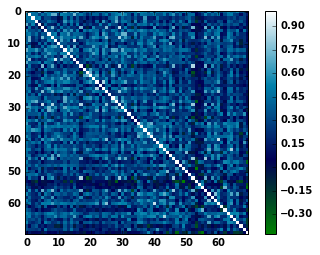

In [24]:
%matplotlib inline
import matplotlib.pylab as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
G1 = np.corrcoef(ts)

plt.imshow(G1, interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
ax.set_xlabel('ROI')
ax.set_ylabel('ROI')
plt.show()